First we try to understand which is the best SVM classifier among Linear, 2nd degree polynomial, radial basis function and their angularized versions, each of which tested with several hyperparameters configurations.

In [52]:
import numpy as np
from svm_classifier import best_hyperparameter_svm, best_hyperparameter_angular_svm
from knn_classifier import k_nn
from time import time
import pandas as pd
from ctypes import cdll, c_float, Structure
from math import sqrt as sqrt
from sys import float_info
from common_utils import cpu_info

if "Intel" in cpu_info():
    from sklearnex import patch_sklearn

    patch_sklearn()

lib = cdll.LoadLibrary("./lib_naive_.so")


class cross_validation_result(Structure):
    _fields_ = [    ("avg_accuracy", c_float),
                    ("min_accuracy", c_float),
                    ("max_accuracy", c_float),
                    ("accuracy_variance", c_float) ]
    def __init__(self):
        self.avg_accuracy = self.accuracy_variance = 0;
        self.min_accuracy = float_info.max;
        self.max_accuracy = float_info.min;
    
    def print_scores(self):
        print( "==========================================================" + "\n" 
                + "Naive bayes classification: " + "\n" 
                + "Minimum Accuracy: " + str(self.min_accuracy) + "\n"
                + "Average Accuracy: " + str(self.avg_accuracy) + "\n"
                + "Maximum Accuracy: " + str(self.max_accuracy) + "\n"
                + "Variance of Accuracy: " + str(self.accuracy_variance) + "\n"
                + "Standard Deviation of Accuracy: " + str(sqrt(self.accuracy_variance)) + "\n" 
                + "=========================================================="
        )



# Load spambase dataset
file_name = "spambase.data"
data = open(file_name, "r")
mailData = np.loadtxt(data, delimiter=",")


# Naive Bayes
lib.py_main.restype = cross_validation_result
start = time()
naive_bayes_score = lib.py_main()
naive_bayes_time = time() - start

# SVMs
start = time()
svm_scores = best_hyperparameter_svm(mailData)
svm_time = time() - start

# Norm SVMs
start = time()
svm_scores = svm_scores + best_hyperparameter_angular_svm(mailData)
svm_norm_time = time() - start

# K-NN
start = time()
knn_score = k_nn(mailData)
knn_time = time() - start



Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


First, we look how the SVM estimators perform:

In [53]:
min_accuracy = []
avg_accuracy = []
max_accuracy = []
support_vectors_numbers = []
elapsed_time = []
var_of_accuracy = []
std_of_accuracy = []
svm_Cs = []
index = []
gammas = []
lowest_min_accuracy = float_info.max;
for score in svm_scores:
    act_min = round(score[0].min() * 100, 4)
    min_accuracy.append(act_min)
    avg_accuracy.append(round(score[0].mean() * 100, 4)) 
    max_accuracy.append(round(score[0].max() * 100, 4)) 
    support_vectors_numbers.append(score[1])
    elapsed_time.append(round(score[2], 4))
    var_of_accuracy.append(score[0].var())
    std_of_accuracy.append(score[0].std())
    svm_Cs.append(score[4])
    gammas.append(round(score[5], 4))
    index.append(score[3])
    lowest_min_accuracy = act_min if lowest_min_accuracy > act_min else lowest_min_accuracy





svm_table = pd.DataFrame(
    {
        "C" : svm_Cs,
        "Gamma": gammas,
        "Minimum Accuracy": min_accuracy,
        "Average Accuracy": avg_accuracy,
        "Maximum Accuracy": max_accuracy,
        "Variance of Accuracy": var_of_accuracy,
        "Standard deviation of Accuracy": std_of_accuracy,
        "Elapsed time": elapsed_time,
        "Number of vectors" : support_vectors_numbers
    },
    index=index
)

svm_table.sort_values(by=['Average Accuracy'])
# svm_table.style.highlight_max(color = 'lightgreen', axis = 1)


,C,Gamma,Minimum Accuracy,Average Accuracy,Maximum Accuracy,Variance of Accuracy,Standard deviation of Accuracy,Elapsed time,Number of vectors
linear SVM,100,1.0000,87.2671,90.1242,93.7888,0.000360,0.018982,0.6281,"[750, 748]"
poly SVM,100,420.0000,88.5093,91.5528,95.3416,0.000335,0.018310,2.4540,"[475, 419]"
Norm linear SVM,25,1.0000,89.4410,92.7019,94.7205,0.000255,0.015972,5.2309,"[306, 292]"
Norm poly SVM,1,1.1312,90.9938,92.9503,95.0311,0.000143,0.011951,0.8468,"[376, 362]"
Norm rbf SVM,1,1.1312,91.3043,93.1677,95.3416,0.000120,0.010936,4.2042,"[398, 386]"
rbf SVM,50,320.2366,91.6149,93.6025,95.0311,0.000130,0.011385,6.3362,"[302, 321]"


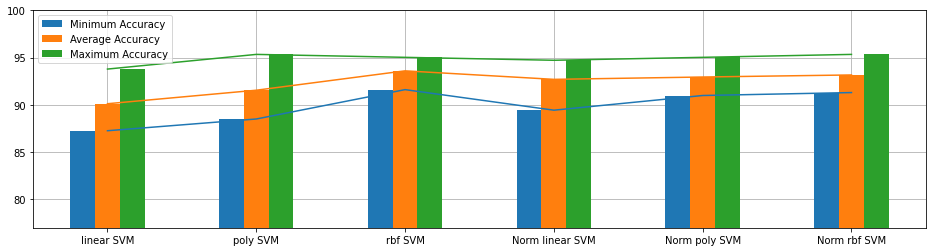

In [54]:
svm_bars = pd.DataFrame(
    {
        "Minimum Accuracy": min_accuracy,
        "Average Accuracy": avg_accuracy,
        "Maximum Accuracy": max_accuracy,
    },
    index=index
)

ax = svm_bars.plot.bar(rot=0, figsize=(16, 4))
ax.set_ylim(int(lowest_min_accuracy - 10) , 100)
ax.grid(True)
ax.set_axisbelow(True)
ax.plot(svm_bars)

As we can see, the angularised version of the RBF SVM always performs better than any other SVM, so we use it to make a comparison between it and all other classifiers.

In [55]:
result = svm_table.iloc[-1]

minimum_accuracy = [
    round(result['Minimum Accuracy'], 4),
    round(knn_score.min() * 100, 4) ,
    round(naive_bayes_score.min_accuracy * 100) 
]
for acc in minimum_accuracy:
    lowest_min_accuracy = acc if lowest_min_accuracy > acc else lowest_min_accuracy
average_accuracy = [
    round(result['Average Accuracy']),
    round(knn_score.mean() * 100, 4) ,
    round(naive_bayes_score.avg_accuracy * 100, 4)
]
maximum_accuracy = [
    round(result['Maximum Accuracy']),
    round(knn_score.max() * 100, 4) ,
    round(naive_bayes_score.max_accuracy * 100, 4) 
]
elapsed_time = [
    result['Elapsed time'],
    knn_time,
    naive_bayes_time
]
var_of_accuracy = [
    result['Variance of Accuracy'],
    knn_score.var(),
    naive_bayes_score.accuracy_variance
]
std_of_accuracy = [
    result['Standard deviation of Accuracy'],
    knn_score.std(),
    sqrt(naive_bayes_score.accuracy_variance)
]
index = [
    result.name,
    "K-NN",
    "Naive Bayes"
]
df_for_table = pd.DataFrame(
    {
        "Minimum Accuracy": minimum_accuracy,
        "Average Accuracy": average_accuracy,
        "Maximum Accuracy": maximum_accuracy,
        "Variance of Accuracy": var_of_accuracy,
        "Standard deviation of Accuracy": std_of_accuracy,
        "Elapsed time": elapsed_time,
    },
    index=index
)

df_for_table.sort_values(by=['Average Accuracy'])

,Minimum Accuracy,Average Accuracy,Maximum Accuracy,Variance of Accuracy,Standard deviation of Accuracy,Elapsed time
Naive Bayes,81.263614,83.860224,87.363833,0.003896,0.062421,0.045894
K-NN,88.260870,91.067245,93.478261,0.000237,0.015380,0.066652
Norm rbf SVM,91.304300,93.167700,95.341600,0.000120,0.010936,4.204200


And we look at these results also from a graphical point of view.

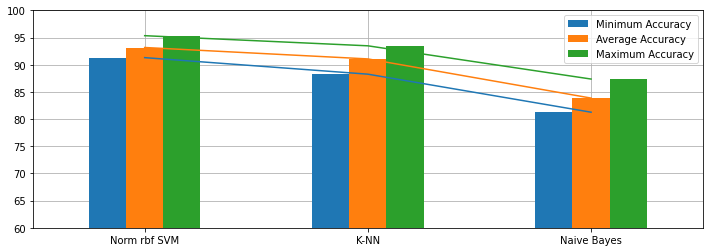

In [56]:
df = pd.DataFrame(
    {
        "Minimum Accuracy": minimum_accuracy,
        "Average Accuracy": average_accuracy,
        "Maximum Accuracy": maximum_accuracy,
    },
    index=index
)

ax = df.plot.bar(rot=0, figsize=(12, 4))
# ax.grid(True, )
ax.set_ylim(int(lowest_min_accuracy) - 10, 100)

# import matplotlib as plt
ax.grid(True)
ax.set_axisbelow(True)
ax.plot(df)



Clearly, the SVM classifier outperforms all classifiers in terms of accuracy.